# Analysis of Alanine dipeptide with no Umbrella sampling

## Relevant imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import simtk.openmm as mm
import simtk.openmm.app as app
from openmmtools.testsystems import AlanineDipeptideExplicit
import mdtraj as md
import seaborn as sns
import pandas as pd
from matplotlib import ticker
import matplotlib as mpl

sns.set()

## Gathering the data

### Obtaining trajectory

In [2]:
# Set the directory path
directory = 'results/alad-015M-15A-run-NOCHARMM-noUS/'

# Get the list of all files in the directory
files = os.listdir(directory)
traj=[]
# Iterate over all the files in the directory
for file in files:
  # Check if the file has the ".chk" extension
    if file.endswith("coords.npy"):
        traj.append(np.load(directory+file))
traj=np.array(traj)

In [3]:
traj.shape

(1000, 50, 22, 3)

In [4]:
#We reshape the trajectories as there are 50 snapshots in each np file
traj=traj.reshape(1000*50,22,3)

### Obtaining topology

In [5]:
topology_default=AlanineDipeptideExplicit().topology

In [6]:
all_top=md.Topology.from_openmm(topology_default)
atom_list=[]
solute_top=md.Topology()
# Iterate over the chains in the original Topology
for chain in all_top.chains:
    # Create a new Chain object in the solute Topology
    solute_chain = solute_top.add_chain()
    # Iterate over the residues in the chain
    for residue in chain.residues:
        # If the residue is a solute (ALA) residue, add it to the solute Topology
        if residue.name != 'HOH':
            solute_top.add_residue(residue.name, solute_chain)
            #We append a list that will hold all the atoms of the same residue
            atom_list.append([])
            for atom in residue.atoms:
                #We append tha atoms to their corresponding last list
                atom_list[-1].append(atom)

#Putting atoms in their residues
solute_residue_list=[]
for residue in solute_top.residues:
    solute_residue_list.append(residue)
for indx, atom_group in enumerate(atom_list):
    for atom in atom_group:
        solute_top.add_atom(atom.name, atom.element, solute_residue_list[indx])
                

# Iterate over the bonds in the solute residues
for bond in all_top.bonds:
    # Get the atoms that are bonded
    atoms=bond
    # If both atoms are in the solute Topology, add the bond
    if atoms[0].residue.name != 'HOH' and atoms[1].residue.name != 'HOH':
        solute_top.add_bond(atoms[0], atoms[1])


### Analyzing the data

In [7]:
def make2dhist(traj, name):
    valphi=md.compute_phi(traj)[1]
    valpsi=md.compute_psi(traj)[1]
    histphi=np.array([value[0] for value in valphi])*180/(np.pi)
    histpsi=np.array([value[0] for value in valpsi])*180/(np.pi)
    h=plt.hist2d(histphi,histpsi, bins=100, norm=mpl.colors.LogNorm())[0]
    plt.xlabel("$\phi$")
    plt.ylabel("$\psi$")
    plt.title("2D histogram for "+str(name))

In [8]:
#Building trajectory
md_traj=md.Trajectory(traj, solute_top)

In [9]:
valphi=md.compute_phi(md_traj)
valpsi=md.compute_psi(md_traj)

In [10]:
dihedrals={
    "$\phi$":valphi[1].T.reshape(1,-1)[0]*180/(np.pi),
    "$\psi$":valpsi[1].T.reshape(1,-1)[0]*180/(np.pi)
}

In [11]:
dihedrals

{'$\\phi$': array([ -67.58905 ,  -68.46616 ,  -57.055458, ..., -141.02965 ,
        -137.39749 , -154.33655 ], dtype=float32),
 '$\\psi$': array([126.969086, 131.37482 , 121.32185 , ..., 128.27779 , 109.06701 ,
        122.05391 ], dtype=float32)}

In [12]:
dihedrals_df=pd.DataFrame(dihedrals)

<Figure size 648x648 with 0 Axes>

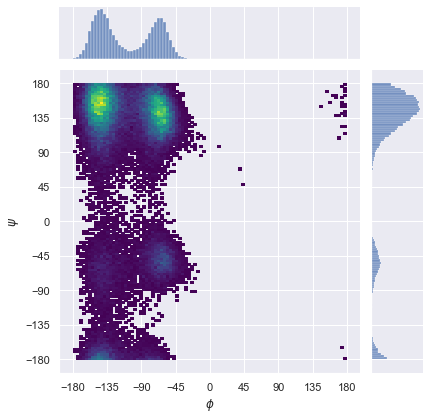

<Figure size 648x648 with 0 Axes>

In [13]:
cmap=mpl.colors.Colormap("jet")
ax=sns.jointplot(data=dihedrals_df,
              x="$\phi$", y="$\psi$",
              kind="hist", cmap="viridis"
                )
ax.ax_joint.xaxis.set_major_locator(ticker.MultipleLocator(45))
ax.ax_joint.yaxis.set_major_locator(ticker.MultipleLocator(45))
plt.figure(figsize=(9,9))

## Energy and Temperature conservation

In [14]:
import pandas as pd

In [15]:
#We make a function to see the mean and avarage
def plot_mean_std(axis,X, array, color="blue", alpha=0.75, **kwargs):
    base=np.zeros(len(array));
    mean=base*0+np.mean(array);std=base*0+np.std(array)
    axis.plot(X,mean, color=color, alpha=alpha, **kwargs)
    axis.fill_between(X, mean-std, mean+std,
                   color=color, alpha=alpha*0.25, zorder=10)

In [16]:
#show data collected
data=pd.read_csv(directory+"alad-015M-15A-scalars-NOCHARMM-noUS.csv")
data

,"#""Time (ps)""",Potential Energy (kJ/mole),Total Energy (kJ/mole),Temperature (K),Speed (ns/day),Elapsed Time (s)
0,2.000000,-31811.649694,-26754.041439,267.674251,--,0.000000
1,4.000000,-30543.901625,-25115.944300,287.275000,32,5.403482
2,6.000000,-30073.529850,-24649.660810,287.058627,31.7,10.887373
3,8.000000,-30007.418572,-24708.710002,280.434501,31.7,16.350434
4,10.000000,-30008.272642,-24246.302838,304.952632,31.7,21.827901
...,...,...,...,...,...,...
4995,9992.000001,-30356.630493,-24682.854347,300.284977,30.3,28516.430631
4996,9994.000001,-30013.782342,-24306.217643,302.073238,30.3,28522.073761
4997,9996.000001,-30027.907957,-24375.182434,299.170871,30.3,28527.737381
4998,9998.000001,-29819.435974,-24268.051183,293.807407,30.3,28533.381586


In [17]:
data.columns

Index(['#"Time (ps)"', 'Potential Energy (kJ/mole)', 'Total Energy (kJ/mole)',
       'Temperature (K)', 'Speed (ns/day)', 'Elapsed Time (s)'],
      dtype='object')

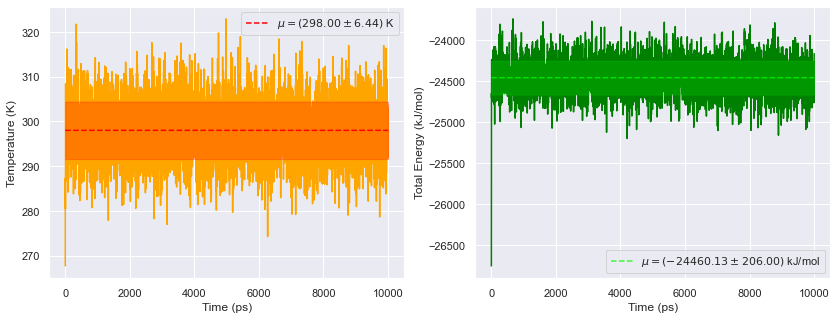

In [18]:
#Plot Temperature and Energy stability
fig, axis=plt.subplots(1,2,figsize=(2*7,5))
t=data['#"Time (ps)"']; T=data['Temperature (K)']; E=data['Total Energy (kJ/mole)']
axis[0].plot(t,T,color="orange", zorder=1)
plot_mean_std(axis[0],t, T, color="red", alpha=1,
             label=f"$\mu=({np.mean(T):.2f}\pm{np.std(T):.2f})$ K",
             linestyle="--", zorder=10)
axis[1].plot(t,E,color="green", zorder=1)
plot_mean_std(axis[1],t, E, color="lime", alpha=0.75,
             label=f"$\mu=({np.mean(E):.2f}\pm{np.std(E):.2f})$ kJ/mol",
             linestyle="--")
axis[1].set_xlabel("Time (ps)"); axis[0].set_ylabel("Temperature (K)")
axis[0].set_xlabel("Time (ps)"); axis[1].set_ylabel("Total Energy (kJ/mol)")
axis[1].legend(); axis[0].legend()